In [ ]:
# PERCENT OF ARRESTS BY UNIT NUMBER
# ARRESTS BY OFFICER ID
# PERCENT OF RACE ARRESTS BY OFFICER
# ZIP CODES WITH HIGHEST NUMBER OF ARRESTS

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [2]:
df_clean = pd.read_csv('ISR_data_clean.csv',low_memory=False)
df_clean.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,HOTSPOT_NO,EVENT_NO,MISSION_NO,CPD_UNIT_NO,CREATED_BY,CREATED_DATE,MODIFIED_BY,MODIFIED_DATE,AGE,AGE_TO,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,STREET_NO,STREET_DIRECTION_CD,STREET_NME,CITY,STATE_CD,ZIP_CD,DISTRICT,SECTOR,BEAT,AREA,RES_DISTRICT,RES_SECTOR,RES_BEAT,RES_AREA,BUS_DISTRICT,BUS_SECTOR,BUS_BEAT,BUS_AREA,SUBMITTING_UNIT,CONTACT_TYPE_DESCR,V_YEAR,MAKE_CD,MAKE_DESCR,STYLE_CD,STYLE_DESCR,MODEL_DESCR,COLOR_TOP,COLOR_BOTTOM,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,GANG,KNOWN_HANGOUT,FACTION_NAME,CONTACT_CARD_STATUS_CD,LOCATION_CD,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,FIREARM_I,COCAINE_I,COCAINE_AMOUNT,HEROIN_I,HEROIN_AMOUNT,OTHER_WEAPON_I,OTHER_WEAPON_DESCR,CANNABIS_I,CANNABIS_AMOUNT,OTHER_CON_SUB_I,OTHER_CON_SUB,OTHER_CON_SUB_AMT,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CONTRABAND_FOUND_I,SEARCH_FIREARM_I,SEARCH_COCAINE_I,SEARCH_COCAINE_AMOUNT,SEARCH_HEROIN_I,SEARCH_HEROIN_AMOUNT,SEARCH_OTHER_WEAPON_I,SEARCH_OTHER_WEAPON_DESCR,SEARCH_CANNABIS_I,SEARCH_CANNABIS_AMOUNT,SEARCH_OTHER_CON_SUB_I,SEARCH_OTHER_CON_SUB_DESCR,SEARCH_OTHER_CON_SUB_AMT,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ENFORCEMENT_ID_NO,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME
0,20410357,INVSTG,ISR000410357,01-JAN-2018 00:08,0,2523,N,"BROWN JACKET, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:46,185285.0,01-JAN-2018 01:47,30.0,NaN,M,WWH,506,165,MED,BRO,BLK,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,16.0,163.0,1634.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN
1,20410350,INVSTG,ISR000410350,01-JAN-2018 00:08,0,2523,N,BLUE JEANS AND A BLACK SWEATER,NaN,JB100012,NaN,121,NaN,25,675642,01-JAN-2018 01:35,675642.0,01-JAN-2018 01:38,20.0,NaN,M,WWH,510,175,MED,BRO,BLK,MED,LBR,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,252.0,2523.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675642,845723.0,184324.0,NaN,NaN,NaN,APP,289,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20410351,INVSTG,ISR000410351,01-JAN-2018 00:08,0,2523,N,"GRAY HOODED SWEATER, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:35,185285.0,01-JAN-2018 01:36,23.0,NaN,M,WWH,508,170,MED,BRO,BAL,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,253.0,2535.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,N

In [3]:
# PERCENT OF ARRESTS BY UNIT NUMBER
# get binary to represent arrest

arrest_count = df_clean[['ENFORCEMENT_TYPE_CD', 'SUBMITTING_UNIT', 'SUBMITTING_BEAT_CD', 'CREATED_BY', 'RACE_CODE_CD', 'FO_EMPLOYEE_ID', 'SO_EMPLOYEE_ID', 'SUPV_EMPLOYEE_ID']]

In [4]:
arrest_count['TARGET'] = np.where(arrest_count['ENFORCEMENT_TYPE_CD'] == 'ARR', 1, 0)
arrest_count.head(20)

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ENFORCEMENT_TYPE_CD,SUBMITTING_UNIT,SUBMITTING_BEAT_CD,CREATED_BY,RACE_CODE_CD,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,TARGET
0,NaN,25,2523,185285,WWH,185285,845723.0,184324.0,0
1,NaN,25,2523,675642,WWH,675642,845723.0,184324.0,0
2,NaN,25,2523,185285,WWH,185285,845723.0,184324.0,0
3,NaN,313,6738,469481,WWH,469481,767063.0,225434.0,0
4,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
5,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
6,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
7,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
8,ARR,14,1461,555358,BLK,555358,614048.0,621961.0,1
9,ARR,14,1461,555358,BLK,555358,614048.0,621961.0,1


In [5]:
# remove lines missing SO_EMPLOYEE_ID
arrest_count.dropna(subset = ["SO_EMPLOYEE_ID"], axis=0, inplace=True)
arrest_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243702 entries, 0 to 290144
Data columns (total 9 columns):
ENFORCEMENT_TYPE_CD    54485 non-null object
SUBMITTING_UNIT        243702 non-null int64
SUBMITTING_BEAT_CD     243702 non-null object
CREATED_BY             243702 non-null int64
RACE_CODE_CD           243702 non-null object
FO_EMPLOYEE_ID         243702 non-null int64
SO_EMPLOYEE_ID         243702 non-null float64
SUPV_EMPLOYEE_ID       243628 non-null float64
TARGET                 243702 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 18.6+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
# remove lines missing SUPV_EMPLOYEE_ID
arrest_count.dropna(subset = ["SUPV_EMPLOYEE_ID"], axis=0, inplace=True)
arrest_count.info()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 243628 entries, 0 to 290144
Data columns (total 9 columns):
ENFORCEMENT_TYPE_CD    54463 non-null object
SUBMITTING_UNIT        243628 non-null int64
SUBMITTING_BEAT_CD     243628 non-null object
CREATED_BY             243628 non-null int64
RACE_CODE_CD           243628 non-null object
FO_EMPLOYEE_ID         243628 non-null int64
SO_EMPLOYEE_ID         243628 non-null float64
SUPV_EMPLOYEE_ID       243628 non-null float64
TARGET                 243628 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 18.6+ MB


In [7]:
#  drop enforcement type, since it informs target

arrest_count.drop(columns = ["ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)
arrest_count.info()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 243628 entries, 0 to 290144
Data columns (total 8 columns):
SUBMITTING_UNIT       243628 non-null int64
SUBMITTING_BEAT_CD    243628 non-null object
CREATED_BY            243628 non-null int64
RACE_CODE_CD          243628 non-null object
FO_EMPLOYEE_ID        243628 non-null int64
SO_EMPLOYEE_ID        243628 non-null float64
SUPV_EMPLOYEE_ID      243628 non-null float64
TARGET                243628 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 16.7+ MB


In [ ]:
# EDA before we move on to the model

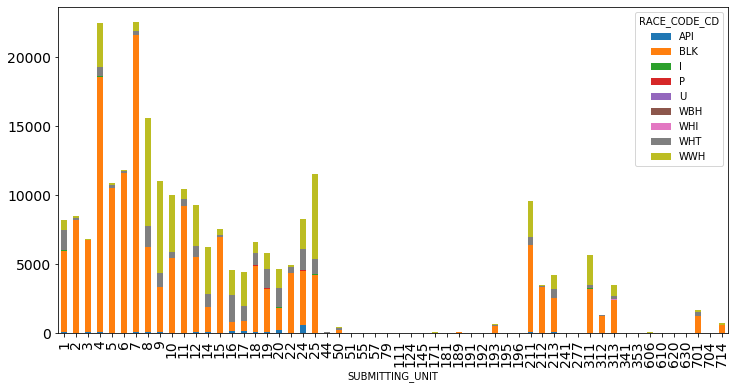

In [8]:
arrest_count.groupby(["SUBMITTING_UNIT","RACE_CODE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=14) 

In [9]:
# percentage of arrests - entire dataset

baseline_arrests = arrest_count[('TARGET')].value_counts(normalize=True) * 100
baseline_arrests

0    88.376952
1    11.623048
Name: TARGET, dtype: float64

In [10]:
first_emp_arrests = arrest_count.groupby('FO_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
first_emp_arrests.sort_values(by='TARGET', ascending=False).head(10)

# interesting - some officers have 100% arrest rates
# they might only have one or two rows in this dataset
# let's limit this to officers that have 20 or more rows

,FO_EMPLOYEE_ID,TARGET
5955,831547,1.0
4267,608301,1.0
4238,604621,1.0
5638,791046,1.0
1153,165553,1.0
1786,253251,1.0
5155,726578,1.0
282,38836,1.0
3199,461201,1.0
3201,461308,1.0


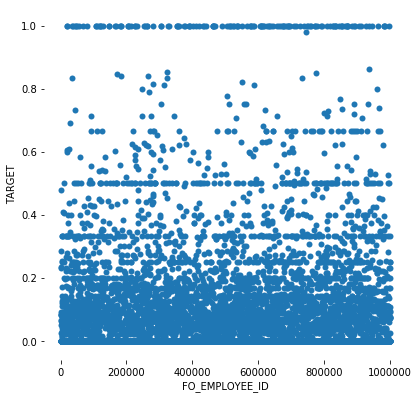

In [11]:
# scatterplot of employee arrest rates

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=first_emp_arrests, ax=ax)

In [12]:
# exclude any officers that have 20 or fewer arrests

filtered = arrest_count.groupby('FO_EMPLOYEE_ID').filter(lambda x: len(x) >= 21)
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213478 entries, 0 to 290144
Data columns (total 8 columns):
SUBMITTING_UNIT       213478 non-null int64
SUBMITTING_BEAT_CD    213478 non-null object
CREATED_BY            213478 non-null int64
RACE_CODE_CD          213478 non-null object
FO_EMPLOYEE_ID        213478 non-null int64
SO_EMPLOYEE_ID        213478 non-null float64
SUPV_EMPLOYEE_ID      213478 non-null float64
TARGET                213478 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 14.7+ MB


In [13]:
filt_first_emp = filtered.groupby('FO_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
highest_50 = filt_first_emp.sort_values(by='TARGET', ascending=False)[:50]

In [14]:
highest_100 = filt_first_emp.sort_values(by='TARGET', ascending=False)[:100]

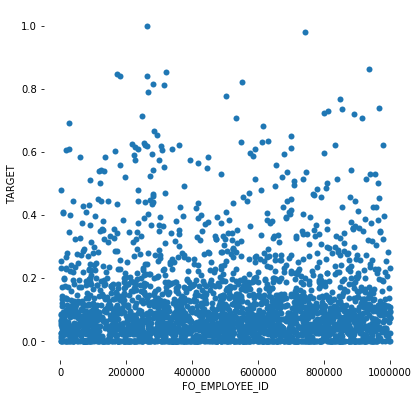

In [15]:
# here are all of the officers with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_first_emp, ax=ax)



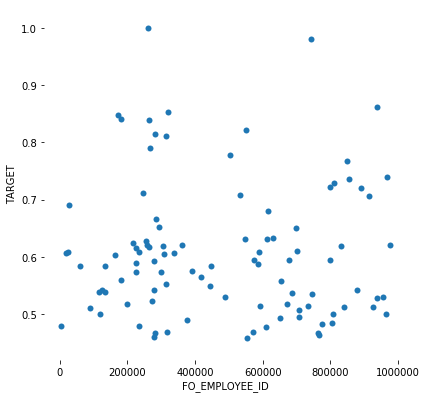

In [16]:
# highest_100 only

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=highest_100, ax=ax)



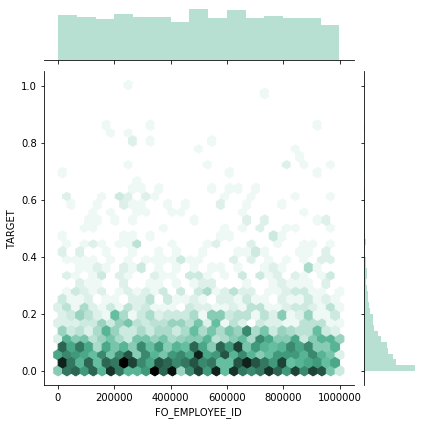

In [17]:
x = filt_first_emp['FO_EMPLOYEE_ID']
y = filt_first_emp['TARGET']

sns.jointplot(x, y, kind="hex", color="#4CB391")

In [ ]:
# let's repeat the same thing, but with supervisors

In [ ]:
arrest_count['SUPV_EMPLOYEE_ID'].nunique()

In [ ]:
supv_arrests = arrest_count.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
supv_arrests.sort_values(by='TARGET', ascending=False).head(10)

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=supv_arrests, ax=ax)

In [ ]:
filtered_supv = arrest_count.groupby('SUPV_EMPLOYEE_ID').filter(lambda x: len(x) >= 21)
filtered_supv.info()

In [ ]:
filt_supv_arrests = filtered_supv.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
highest_50_supv = filt_supv_arrests.sort_values(by='TARGET', ascending=False).head(50)
highest_50_supv

In [ ]:
# here are all of the supervisors with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_supv_arrests, ax=ax)

In [ ]:
# highest_50_supv only

# here are all of the supervisors with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=highest_50_supv, ax=ax)

In [ ]:
x = filt_supv_arrests['SUPV_EMPLOYEE_ID']
y = filt_supv_arrests['TARGET']

sns.jointplot(x, y, kind="hex", color="#4CB391")

In [ ]:
# check to see if this changes with greater than 100 arrests

filtered_supv_100 = arrest_count.groupby('SUPV_EMPLOYEE_ID').filter(lambda x: len(x) >= 101)
filtered_supv_100.info()

In [ ]:
filt_supv_arrests_100 = filtered_supv_100.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()

In [ ]:
# here are the supervisors with more than 100 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_supv_arrests_100, ax=ax)

In [ ]:
x = filt_supv_arrests_100['SUPV_EMPLOYEE_ID']
y = filt_supv_arrests_100['TARGET']

sns.jointplot(x, y, kind="hex", color="#4CB391")

In [ ]:
# one last chart - count of arrests vs. mean target

In [ ]:
# list out 50 worst officers
# target is "worst" list
# based on non-admin info, can we determine whether or not an arrest is from one of those 20?

In [18]:
# reset our index

highest_100.reset_index(drop=True, inplace=True)
highest_100.head()

,FO_EMPLOYEE_ID,TARGET
0,262036,1.000000
1,742961,0.980769
2,936724,0.861111
3,321618,0.852459
4,172179,0.847458


In [19]:
officer_id_list = highest_100['FO_EMPLOYEE_ID'].tolist()
officer_id_list

[262036,
 742961,
 936724,
 321618,
 172179,
 182526,
 264134,
 550037,
 280368,
 315172,
 266758,
 503311,
 848820,
 966601,
 854212,
 810090,
 800075,
 890525,
 246726,
 533328,
 913089,
 27357,
 614407,
 284218,
 292548,
 697816,
 630682,
 547176,
 611367,
 253928,
 216973,
 977291,
 360506,
 257912,
 831325,
 306571,
 264102,
 225187,
 700431,
 234679,
 590225,
 25384,
 337304,
 18303,
 309747,
 164957,
 800251,
 575508,
 678739,
 279273,
 224513,
 585016,
 448605,
 135158,
 58963,
 392445,
 226688,
 300586,
 417478,
 181539,
 653750,
 315721,
 445579,
 880097,
 124570,
 280244,
 117151,
 134083,
 687086,
 744489,
 955019,
 487230,
 938501,
 271480,
 672678,
 197782,
 591567,
 734747,
 839480,
 926695,
 90845,
 706906,
 119602,
 808481,
 963664,
 707649,
 651814,
 375781,
 806260,
 776800,
 2571,
 235297,
 609127,
 570985,
 316822,
 764897,
 281081,
 767927,
 279839,
 553722]

In [20]:
df_arrests = df_clean.copy()

In [21]:
# create binary column for officer id (this will be the target)

df_arrests['HIGHEST_100_OFFICERS'] = np.isin(df_arrests['FO_EMPLOYEE_ID'], officer_id_list)
df_arrests.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,HOTSPOT_NO,EVENT_NO,MISSION_NO,CPD_UNIT_NO,CREATED_BY,CREATED_DATE,MODIFIED_BY,MODIFIED_DATE,AGE,AGE_TO,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,STREET_NO,STREET_DIRECTION_CD,STREET_NME,CITY,STATE_CD,ZIP_CD,DISTRICT,SECTOR,BEAT,AREA,RES_DISTRICT,RES_SECTOR,RES_BEAT,RES_AREA,BUS_DISTRICT,BUS_SECTOR,BUS_BEAT,BUS_AREA,SUBMITTING_UNIT,CONTACT_TYPE_DESCR,V_YEAR,MAKE_CD,MAKE_DESCR,STYLE_CD,STYLE_DESCR,MODEL_DESCR,COLOR_TOP,COLOR_BOTTOM,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,GANG,KNOWN_HANGOUT,FACTION_NAME,CONTACT_CARD_STATUS_CD,LOCATION_CD,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,FIREARM_I,COCAINE_I,COCAINE_AMOUNT,HEROIN_I,HEROIN_AMOUNT,OTHER_WEAPON_I,OTHER_WEAPON_DESCR,CANNABIS_I,CANNABIS_AMOUNT,OTHER_CON_SUB_I,OTHER_CON_SUB,OTHER_CON_SUB_AMT,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CONTRABAND_FOUND_I,SEARCH_FIREARM_I,SEARCH_COCAINE_I,SEARCH_COCAINE_AMOUNT,SEARCH_HEROIN_I,SEARCH_HEROIN_AMOUNT,SEARCH_OTHER_WEAPON_I,SEARCH_OTHER_WEAPON_DESCR,SEARCH_CANNABIS_I,SEARCH_CANNABIS_AMOUNT,SEARCH_OTHER_CON_SUB_I,SEARCH_OTHER_CON_SUB_DESCR,SEARCH_OTHER_CON_SUB_AMT,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ENFORCEMENT_ID_NO,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME,HIGHEST_100_OFFICERS
0,20410357,INVSTG,ISR000410357,01-JAN-2018 00:08,0,2523,N,"BROWN JACKET, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:46,185285.0,01-JAN-2018 01:47,30.0,NaN,M,WWH,506,165,MED,BRO,BLK,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,16.0,163.0,1634.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,False
1,20410350,INVSTG,ISR000410350,01-JAN-2018 00:08,0,2523,N,BLUE JEANS AND A BLACK SWEATER,NaN,JB100012,NaN,121,NaN,25,675642,01-JAN-2018 01:35,675642.0,01-JAN-2018 01:38,20.0,NaN,M,WWH,510,175,MED,BRO,BLK,MED,LBR,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,252.0,2523.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675642,845723.0,184324.0,NaN,NaN,NaN,APP,289,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,20410351,INVSTG,ISR000410351,01-JAN-2018 00:08,0,2523,N,"GRAY HOODED SWEATER, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:35,185285.0,01-JAN-2018 01:36,23.0,NaN,M,WWH,508,170,MED,BRO,BAL,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,253.0,2535.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [22]:
df_arrests['HIGHEST_100_OFFICERS'].value_counts()

False    281014
True       9131
Name: HIGHEST_100_OFFICERS, dtype: int64

In [ ]:
# can we build a model that predicts if the arrest was made by one of the 20 "worst" officers?

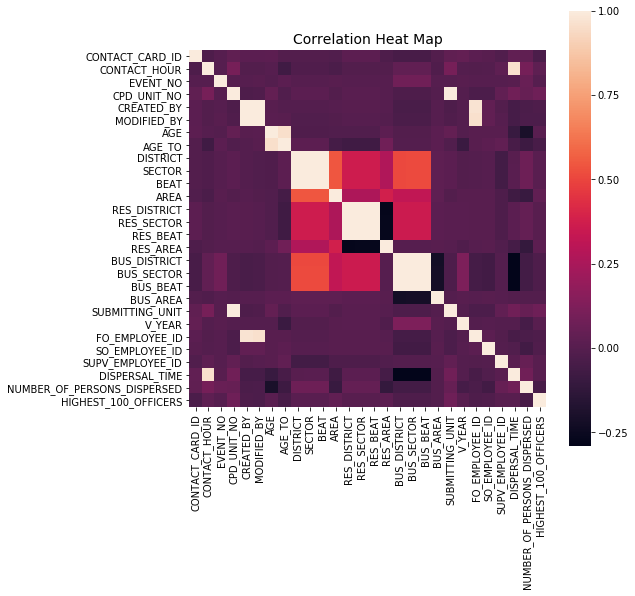

In [23]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [24]:
# remove columns with unit and beat identifying info, supervisor info, created by and modified by, etc.

df_arrests.drop(columns = ["CPD_UNIT_NO", "CREATED_BY", "MODIFIED_BY", "DISTRICT", "SECTOR", "BEAT", "RES_DISTRICT", "RES_SECTOR", "RES_BEAT"], axis=0, inplace=True)

In [25]:
# remove "duplicate" info - eg dispersal time and contact hour
df_arrests.drop(columns = ["DISPERSAL_TIME", "AGE_TO"], axis=0, inplace=True)

In [26]:
# still removing

df_arrests.drop(columns = ["SUBMITTING_UNIT", "FO_EMPLOYEE_ID", "SO_EMPLOYEE_ID", "SUPV_EMPLOYEE_ID"], axis=0, inplace=True)

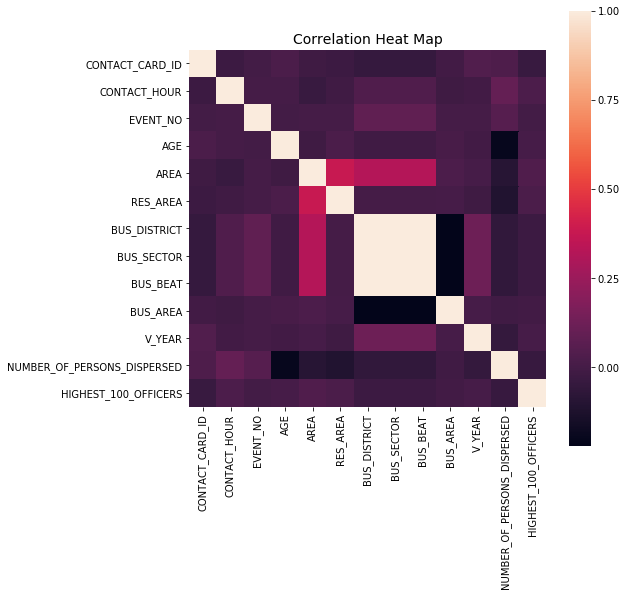

In [27]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [28]:
# also remove: CARD_NO, SUBMITTING_BEAT_CD, RD_NO, MODIFIED_DATE, STREET_NO, STREET_DIRECTION_CD, STREET_NME, CITY, STATE_CD, RES_AREA 

df_arrests.drop(columns = ["CARD_NO", "SUBMITTING_BEAT_CD", "RD_NO", "MODIFIED_DATE", "STREET_NO", "STREET_DIRECTION_CD", "STREET_NME", "CITY", "STATE_CD", "RES_AREA"], axis=0, inplace=True)

In [29]:
df_arrests.drop(columns = ["CLOTHING_DESCR", "EVENT_NO", "BUS_DISTRICT", "BUS_SECTOR", "BUS_BEAT", "BUS_AREA", "CONTACT_TYPE_DESCR"], axis=0, inplace=True)

In [30]:
df_arrests.drop(columns = ["CONTACT_CARD_ID", "CONTACT_DATE", "CONTACT_CARD_STATUS_CD", "LOCATION_CD"], axis=0, inplace=True)

In [31]:
df_arrests.drop(columns = ["V_YEAR", "MAKE_CD", "MAKE_DESCR", "STYLE_CD", "STYLE_DESCR", "MODEL_DESCR", "COLOR_TOP", "COLOR_BOTTOM"], axis=0, inplace=True)

In [32]:
df_arrests.drop(columns = ["FIREARM_I", "COCAINE_I", "COCAINE_AMOUNT", "HEROIN_I", "HEROIN_AMOUNT", "OTHER_WEAPON_I", "OTHER_WEAPON_DESCR", "CANNABIS_I", "CANNABIS_AMOUNT", "OTHER_CON_SUB_I", "OTHER_CON_SUB", "OTHER_CON_SUB_AMT"], axis=0, inplace=True)

In [33]:
df_arrests.drop(columns = ["SEARCH_CONTRABAND_FOUND_I","SEARCH_FIREARM_I", "SEARCH_COCAINE_I", "SEARCH_COCAINE_AMOUNT", "SEARCH_HEROIN_I", "SEARCH_HEROIN_AMOUNT", "SEARCH_OTHER_WEAPON_I", "SEARCH_OTHER_WEAPON_DESCR"], axis=0, inplace=True)

In [34]:
df_arrests.drop(columns = ["S_OTHER_DESCR", "S_OTHER_I", "OTHER_DESCR", "GANG_OTHER", "S_STOLEN_PROPERTY_I", "S_PARA_I", "S_ALCOHOL_I", "SEARCH_PROPERTY_I"], axis=0, inplace=True)

In [35]:
df_arrests.drop(columns = ["STOLEN_PROPERTY_I", "PARA_I", "SEARCH_OTHER_CON_SUB_DESCR", "SEARCH_OTHER_CON_SUB_AMT", "ENFORCEMENT_ID_NO"], axis=0, inplace=True)

In [36]:
df_arrests.drop(columns = ["SEARCH_CANNABIS_AMOUNT", "HOTSPOT_NO", "MISSION_NO"], axis=0, inplace=True)

In [37]:
df_arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290145 entries, 0 to 290144
Data columns (total 57 columns):
CONTACT_TYPE_CD                  290145 non-null object
CONTACT_HOUR                     290145 non-null int64
JUVENILE_I                       290145 non-null object
NAME_VERIFIED_I                  126758 non-null object
CREATED_DATE                     290145 non-null object
AGE                              289342 non-null float64
SEX_CODE_CD                      290145 non-null object
RACE_CODE_CD                     290145 non-null object
HEIGHT                           290145 non-null object
WEIGHT                           290145 non-null object
BUILD_CODE_CD                    290145 non-null object
EYE_COLOR_CODE_CD                290145 non-null object
HAIR_COLOR_CODE_CD               290145 non-null object
HAIR_STYLE_CODE_CD               290145 non-null object
COMPLEXION_CODE_CD               290145 non-null object
ZIP_CD                           289734 non-null 

In [38]:
# change target true/false to binary

df_arrests['HIGHEST_100_OFFICERS'] = np.where(df_arrests['HIGHEST_100_OFFICERS'] == True, 1, 0)

In [39]:
label_encoder_contact_type = LabelEncoder()
label_encoder_contact_type = label_encoder_contact_type.fit(y)
label_encoded_y = label_encoder_contact_type.transform(y)

In [40]:
df_arrests['CONTACT_TYPE_CD'] = label_encoder_contact_type.fit_transform(df_arrests['CONTACT_TYPE_CD'])

In [41]:
label_encoder_juvenile = LabelEncoder()
label_encoder_juvenile = label_encoder_juvenile.fit(y)
label_encoded_y = label_encoder_juvenile.transform(y)

In [42]:
df_arrests['JUVENILE_I'] = label_encoder_contact_type.fit_transform(df_arrests['JUVENILE_I'])

In [43]:
# make name_verified binary

df_arrests['NAME_VERIFIED_I'] = np.where(df_arrests['NAME_VERIFIED_I'] == 'Y', 1, 0)

In [44]:
label_encoder_gender = LabelEncoder()
label_encoder_gender = label_encoder_gender.fit(y)
label_encoded_y = label_encoder_gender.transform(y)

In [45]:
df_arrests['SEX_CODE_CD'] = label_encoder_gender.fit_transform(df_arrests['SEX_CODE_CD'])

In [46]:
label_encoder_race = LabelEncoder()
label_encoder_race = label_encoder_race.fit(y)
label_encoded_y = label_encoder_race.transform(y)

In [47]:
df_arrests['RACE_CODE_CD'] = label_encoder_race.fit_transform(df_arrests['RACE_CODE_CD'])

In [48]:
label_encoder_build = LabelEncoder()
label_encoder_build = label_encoder_build.fit(y)
label_encoded_y = label_encoder_build.transform(y)

In [49]:
df_arrests['BUILD_CODE_CD'] = label_encoder_build.fit_transform(df_arrests['BUILD_CODE_CD'])

In [50]:
label_encoder_eye = LabelEncoder()
label_encoder_eye = label_encoder_eye.fit(y)
label_encoded_y = label_encoder_eye.transform(y)

In [51]:
df_arrests['EYE_COLOR_CODE_CD'] = label_encoder_eye.fit_transform(df_arrests['EYE_COLOR_CODE_CD'])

In [52]:
label_encoder_hair = LabelEncoder()
label_encoder_hair = label_encoder_hair.fit(y)
label_encoded_y = label_encoder_hair.transform(y)

In [53]:
df_arrests['HAIR_COLOR_CODE_CD'] = label_encoder_hair.fit_transform(df_arrests['HAIR_COLOR_CODE_CD'])

In [54]:
label_encoder_style = LabelEncoder()
label_encoder_style = label_encoder_style.fit(y)
label_encoded_y = label_encoder_style.transform(y)

In [55]:
df_arrests['HAIR_STYLE_CODE_CD'] = label_encoder_style.fit_transform(df_arrests['HAIR_STYLE_CODE_CD'])

In [56]:
#df_arrests['GANG'].value_counts()
df_arrests.drop(columns = ["GANG"], axis=0, inplace=True)

In [57]:
df_arrests.drop(columns = ["KNOWN_HANGOUT", "FACTION_NAME"], axis=0, inplace=True)

In [58]:
df_arrests["NUMBER_OF_PERSONS_DISPERSED"] = df_arrests["NUMBER_OF_PERSONS_DISPERSED"].fillna(0)

In [59]:
df_arrests['GANG_LOOKOUT_I'] = np.where(df_arrests['GANG_LOOKOUT_I'] == 'Y', 1, 0)

In [60]:
df_arrests['VEHICLE_INVOLVED_I'] = np.where(df_arrests['VEHICLE_INVOLVED_I'] == 'Y', 1, 0)

In [61]:
df_arrests['GANG_SECURITY_I'] = np.where(df_arrests['GANG_SECURITY_I'] == 'Y', 1, 0)

In [62]:
df_arrests['INTIMIDATION_I'] = np.where(df_arrests['INTIMIDATION_I'] == 'Y', 1, 0)

In [63]:
df_arrests['SUSPECT_NARCOTIC_ACTIVITY_I'] = np.where(df_arrests['SUSPECT_NARCOTIC_ACTIVITY_I'] == 'Y', 1, 0)

In [64]:
df_arrests['INDICATIVE_DRUG_TRANSACTION_I'] = np.where(df_arrests['INDICATIVE_DRUG_TRANSACTION_I'] == 'Y', 1, 0)

In [65]:
df_arrests['INDICATIVE_CASING_I'] = np.where(df_arrests['INDICATIVE_CASING_I'] == 'Y', 1, 0)

In [66]:
df_arrests['FITS_DESCRIPTION_I'] = np.where(df_arrests['FITS_DESCRIPTION_I'] == 'Y', 1, 0)

In [67]:
df_arrests['PROXIMITY_TO_CRIME_I'] = np.where(df_arrests['PROXIMITY_TO_CRIME_I'] == 'Y', 1, 0)

In [68]:
df_arrests['FITS_DESCRIPTION_OFFENDER_I'] = np.where(df_arrests['FITS_DESCRIPTION_OFFENDER_I'] == 'Y', 1, 0)

In [69]:
df_arrests['GANG_NARCOTIC_RELATED_I'] = np.where(df_arrests['GANG_NARCOTIC_RELATED_I'] == 'Y', 1, 0)

In [70]:
df_arrests['OTHER_FACTOR_I'] = np.where(df_arrests['OTHER_FACTOR_I'] == 'Y', 1, 0)

In [71]:
df_arrests['PAT_DOWN_I'] = np.where(df_arrests['PAT_DOWN_I'] == 'Y', 1, 0)

In [72]:
df_arrests['PAT_DOWN_CONSENT_I'] = np.where(df_arrests['PAT_DOWN_CONSENT_I'] == 'Y', 1, 0)

In [73]:
df_arrests['PAT_DOWN_RECEIPT_GIVEN_I'] = np.where(df_arrests['PAT_DOWN_RECEIPT_GIVEN_I'] == 'Y', 1, 0)

In [74]:
df_arrests['VERBAL_THREATS_I'] = np.where(df_arrests['VERBAL_THREATS_I'] == 'Y', 1, 0)

In [75]:
df_arrests['KNOWLEDGE_OF_PRIOR_I'] = np.where(df_arrests['KNOWLEDGE_OF_PRIOR_I'] == 'Y', 1, 0)

In [76]:
df_arrests['ACTIONS_INDICATIVE_VIOLENCE_I'] = np.where(df_arrests['ACTIONS_INDICATIVE_VIOLENCE_I'] == 'Y', 1, 0)

In [77]:
df_arrests['VIOLENT_CRIME_I'] = np.where(df_arrests['VIOLENT_CRIME_I'] == 'Y', 1, 0)

In [78]:
df_arrests['SUSPICIOUS_OBJECT_I'] = np.where(df_arrests['SUSPICIOUS_OBJECT_I'] == 'Y', 1, 0)

In [79]:
df_arrests['OTHER_REASONABLE_SUSPICION_I'] = np.where(df_arrests['OTHER_REASONABLE_SUSPICION_I'] == 'Y', 1, 0)

In [80]:
df_arrests['WEAPON_OR_CONTRABAND_FOUND_I'] = np.where(df_arrests['WEAPON_OR_CONTRABAND_FOUND_I'] == 'Y', 1, 0)

In [81]:
df_arrests['SEARCH_I'] = np.where(df_arrests['SEARCH_I'] == 'Y', 1, 0)

In [82]:
df_arrests['SEARCH_CONSENT_I'] = np.where(df_arrests['SEARCH_CONSENT_I'] == 'Y', 1, 0)

In [83]:
df_arrests['SEARCH_CANNABIS_I'] = np.where(df_arrests['SEARCH_CANNABIS_I'] == 'Y', 1, 0)

In [84]:
df_arrests['SEARCH_OTHER_CON_SUB_I'] = np.where(df_arrests['SEARCH_OTHER_CON_SUB_I'] == 'Y', 1, 0)

In [85]:
df_arrests['SEARCH_CONSENT_I'] = np.where(df_arrests['SEARCH_CONSENT_I'] == 'Y', 1, 0)

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [86]:
df_arrests['BODY_CAMERA_I'] = np.where(df_arrests['BODY_CAMERA_I'] == 'Y', 1, 0)

In [87]:
df_arrests['CAR_CAMERA_I'] = np.where(df_arrests['CAR_CAMERA_I'] == 'Y', 1, 0)

In [88]:
df_arrests['INFORMATION_REFUSED_I'] = np.where(df_arrests['INFORMATION_REFUSED_I'] == 'Y', 1, 0)

In [89]:
df_arrests['GANG_OTHER_I'] = np.where(df_arrests['GANG_OTHER_I'] == 'Y', 1, 0)

In [90]:
df_arrests['ALCOHOL_I'] = np.where(df_arrests['ALCOHOL_I'] == 'Y', 1, 0)

In [91]:
df_arrests.drop(columns = ["NAME"], axis=0, inplace=True)

In [92]:
df_arrests['WEIGHT'].nunique()

372

In [93]:
df_arrests.drop(columns = ["WEIGHT"], axis=0, inplace=True)

In [94]:
df_arrests.drop(columns = ["HEIGHT"], axis=0, inplace=True)

In [95]:
df_arrests.head()

,CONTACT_TYPE_CD,CONTACT_HOUR,JUVENILE_I,NAME_VERIFIED_I,CREATED_DATE,AGE,SEX_CODE_CD,RACE_CODE_CD,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,ZIP_CD,AREA,VEHICLE_INVOLVED_I,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CANNABIS_I,SEARCH_OTHER_CON_SUB_I,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ALCOHOL_I,HIGHEST_100_OFFICERS
0,1,0,0,0,01-JAN-2018 01:46,30.0,1,8,3,2,1,22,MED,60641,3,0,0.0,0,0,0,0,N,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,OEMC,1,0,0,1,NaN,0,0
1,1,0,0,0,01-JAN-2018 01:35,20.0,1,8,3,2,1,14,LBR,60641,3,0,0.0,0,0,0,0,N,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,OEMC,1,0,0,0,NaN,0,0
2,1,0,0,0,01-JAN-2018 01:35,23.0,1,8,3,2,0,22,MED,60641,3,0,0.0,0,0,0,0,N,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,OEMC,1,0,0,1,NaN,0,0
3,1,0,0,1,01-JAN-2018 01:01,23.0,1,8,0,2,1,20,MBR,60634,3,0,0.0,0,0,0,0,N,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,VIEW,0,0,0,0,NaN,0,0
4,1,0,0,1,01-JAN-2018 01:36,27.0,1,1,4,2,1,22,MED,60621,2,1,0.0,0,0,0,0,N,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,VIEW,1,0,0,0,NaN,0,0


In [96]:
label_encoder_assign = LabelEncoder()
label_encoder_assign = label_encoder_assign.fit(y)
label_encoded_y = label_encoder_assign.transform(y)

In [97]:
df_arrests['EVENT_ASSIGNEED_BY_CD'] = label_encoder_assign.fit_transform(df_arrests['EVENT_ASSIGNEED_BY_CD'])

In [98]:
df_arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290145 entries, 0 to 290144
Data columns (total 51 columns):
CONTACT_TYPE_CD                  290145 non-null int64
CONTACT_HOUR                     290145 non-null int64
JUVENILE_I                       290145 non-null int64
NAME_VERIFIED_I                  290145 non-null int64
CREATED_DATE                     290145 non-null object
AGE                              289342 non-null float64
SEX_CODE_CD                      290145 non-null int64
RACE_CODE_CD                     290145 non-null int64
BUILD_CODE_CD                    290145 non-null int64
EYE_COLOR_CODE_CD                290145 non-null int64
HAIR_COLOR_CODE_CD               290145 non-null int64
HAIR_STYLE_CODE_CD               290145 non-null int64
COMPLEXION_CODE_CD               290145 non-null object
ZIP_CD                           289734 non-null object
AREA                             290145 non-null int64
VEHICLE_INVOLVED_I               290145 non-null int64
NUMB

In [99]:
df_arrests['SEARCH_CONSENT_I'].value_counts()

0    290145
Name: SEARCH_CONSENT_I, dtype: int64

In [100]:
# check info again

df_arrests.isna().sum()

CONTACT_TYPE_CD                       0
CONTACT_HOUR                          0
JUVENILE_I                            0
NAME_VERIFIED_I                       0
CREATED_DATE                          0
AGE                                 803
SEX_CODE_CD                           0
RACE_CODE_CD                          0
BUILD_CODE_CD                         0
EYE_COLOR_CODE_CD                     0
HAIR_COLOR_CODE_CD                    0
HAIR_STYLE_CODE_CD                    0
COMPLEXION_CODE_CD                    0
ZIP_CD                              411
AREA                                  0
VEHICLE_INVOLVED_I                    0
NUMBER_OF_PERSONS_DISPERSED           0
GANG_LOOKOUT_I                        0
GANG_SECURITY_I                       0
INTIMIDATION_I                        0
SUSPECT_NARCOTIC_ACTIVITY_I           0
ENFORCEMENT_ACTION_TAKEN_I            0
INDICATIVE_DRUG_TRANSACTION_I         0
INDICATIVE_CASING_I                   0
FITS_DESCRIPTION_I                    0


In [101]:
# drop rows with missing values
df_arrests.dropna(subset = ["ZIP_CD", "AGE"], axis=0, inplace=True)
df_arrests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288931 entries, 0 to 290144
Data columns (total 51 columns):
CONTACT_TYPE_CD                  288931 non-null int64
CONTACT_HOUR                     288931 non-null int64
JUVENILE_I                       288931 non-null int64
NAME_VERIFIED_I                  288931 non-null int64
CREATED_DATE                     288931 non-null object
AGE                              288931 non-null float64
SEX_CODE_CD                      288931 non-null int64
RACE_CODE_CD                     288931 non-null int64
BUILD_CODE_CD                    288931 non-null int64
EYE_COLOR_CODE_CD                288931 non-null int64
HAIR_COLOR_CODE_CD               288931 non-null int64
HAIR_STYLE_CODE_CD               288931 non-null int64
COMPLEXION_CODE_CD               288931 non-null object
ZIP_CD                           288931 non-null object
AREA                             288931 non-null int64
VEHICLE_INVOLVED_I               288931 non-null int64
NUMB

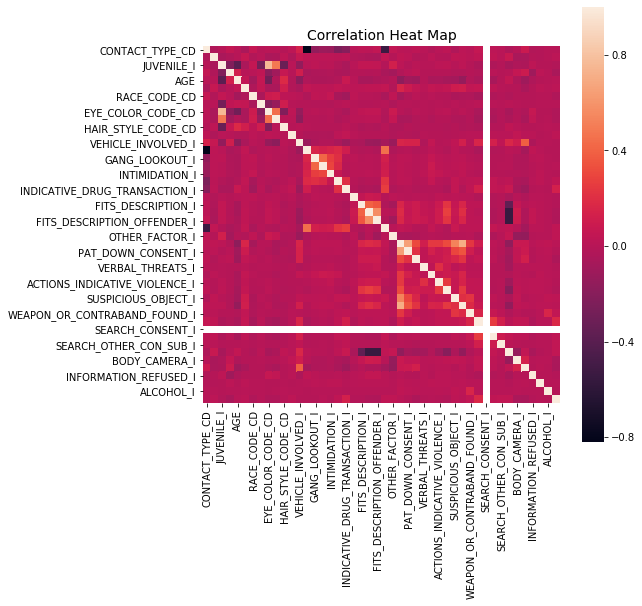

In [102]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [103]:
# saving this cleaned df to csv

df_model_clean = df_arrests
df_model_clean.to_csv('ISR_data_clean_TS.csv', index=False)

In [104]:
label_encoder_comp = LabelEncoder()
label_encoder_comp = label_encoder_comp.fit(y)
label_encoded_y = label_encoder_comp.transform(y)

In [105]:
df_arrests['COMPLEXION_CODE_CD'] = label_encoder_comp.fit_transform(df_arrests['COMPLEXION_CODE_CD'])

In [106]:
df_arrests.drop(columns = ["SEARCH_CONSENT_I", "ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)

In [107]:
df_arrests.drop(columns = ["ENFORCEMENT_ACTION_TAKEN_I"], axis=0, inplace=True)

In [108]:
df_arrests= df_arrests.drop(['CREATED_DATE'], axis = 1)

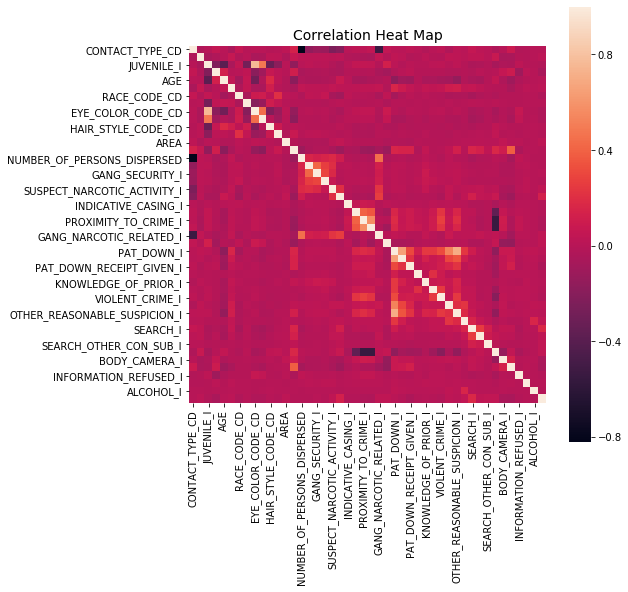

In [109]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [110]:
y = df_arrests['HIGHEST_100_OFFICERS']

In [111]:
y.value_counts()

0    279816
1      9115
Name: HIGHEST_100_OFFICERS, dtype: int64

In [112]:
# run this after pasting all of the column names in

df_arrests = pd.get_dummies(df_arrests, columns=['CONTACT_HOUR', 'AGE', 'SEX_CODE_CD', 'RACE_CODE_CD', 'BUILD_CODE_CD', 'EYE_COLOR_CODE_CD', 'HAIR_COLOR_CODE_CD', 'HAIR_STYLE_CODE_CD', 'COMPLEXION_CODE_CD', 'AREA', 'NUMBER_OF_PERSONS_DISPERSED'])
df_arrests.head()

,CONTACT_TYPE_CD,JUVENILE_I,NAME_VERIFIED_I,ZIP_CD,VEHICLE_INVOLVED_I,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,SEARCH_I,SEARCH_CANNABIS_I,SEARCH_OTHER_CON_SUB_I,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ALCOHOL_I,HIGHEST_100_OFFICERS,CONTACT_HOUR_0,CONTACT_HOUR_1,CONTACT_HOUR_2,CONTACT_HOUR_3,CONTACT_HOUR_4,CONTACT_HOUR_5,CONTACT_HOUR_6,CONTACT_HOUR_7,CONTACT_HOUR_8,CONTACT_HOUR_9,CONTACT_HOUR_10,CONTACT_HOUR_11,CONTACT_HOUR_12,CONTACT_HOUR_13,CONTACT_HOUR_14,CONTACT_HOUR_15,CONTACT_HOUR_16,CONTACT_HOUR_17,CONTACT_HOUR_18,CONTACT_HOUR_19,CONTACT_HOUR_20,CONTACT_HOUR_21,CONTACT_HOUR_22,CONTACT_HOUR_23,AGE_0.0,AGE_1.0,AGE_3.0,AGE_4.0,AGE_5.0,AGE_6.0,AGE_7.0,AGE_8.0,AGE_9.0,AGE_10.0,AGE_11.0,AGE_12.0,AGE_13.0,AGE_14.0,AGE_15.0,AGE_16.0,AGE_17.0,AGE_18.0,AGE_19.0,AGE_20.0,AGE_21.0,AGE_22.0,AGE_23.0,AGE_24.0,AGE_25.0,AGE_26.0,AGE_27.0,AGE_28.0,AGE_29.0,AGE_30.0,AGE_31.0,AGE_32.0,AGE_33.0,AGE_34.0,AGE_35.0,AGE_36.0,AGE_37.0,AGE_38.0,AGE_39.0,AGE_40.0,AGE_41.0,AGE_42.0,AGE_43.0,AGE_44.0,AGE_45.0,AGE_46.0,AGE_47.0,AGE_48.0,AGE_49.0,AGE_50.0,AGE_51.0,AGE_52.0,AGE_53.0,AGE_54.0,AGE_55.0,AGE_56.0,AGE_57.0,AGE_58.0,AGE_59.0,AGE_60.0,AGE_61.0,AGE_62.0,AGE_63.0,AGE_64.0,AGE_65.0,AGE_66.0,AGE_67.0,AGE_68.0,AGE_69.0,AGE_70.0,AGE_71.0,AGE_72.0,AGE_73.0,AGE_74.0,AGE_75.0,AGE_76.0,AGE_77.0,AGE_78.0,AGE_79.0,AGE_80.0,AGE_81.0,AGE_82.0,AGE_83.0,AGE_84.0,AGE_85.0,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_90.0,AGE_91.0,AGE_92.0,AGE_93.0,AGE_94.0,AGE_99.0,AGE_100.0,AGE_109.0,AGE_112.0,AGE_115.0,AGE_116.0,AGE_117.0,AGE_118.0,AGE_119.0,AGE_120.0,AGE_122.0,AGE_130.0,AGE_133.0,AGE_135.0,AGE_138.0,AGE_144.0,AGE_146.0,AGE_147.0,AGE_167.0,AGE_320.0,AGE_631.0,AGE_720.0,AGE_819.0,AGE_821.0,AGE_822.0,AGE_823.0,AGE_824.0,AGE_852.0,AGE_922.0,AGE_928.0,AGE_931.0,AGE_934.0,AGE_942.0,AGE_946.0,AGE_957.0,SEX_CODE_CD_0,SEX_CODE_CD_1,SEX_CODE_CD_2,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8,BUILD_CODE_CD_0,BUILD_CODE_CD_1,BUILD_CODE_CD_2,BUILD_CODE_CD_3,BUILD_CODE_CD_4,BUILD_CODE_CD_5,EYE_COLOR_CODE_CD_0,EYE_COLOR_CODE_CD_1,EYE_COLOR_CODE_CD_2,EYE_COLOR_CODE_CD_3,EYE_COLOR_CODE_CD_4,EYE_COLOR_CODE_CD_5,EYE_COLOR_CODE_CD_6,EYE_COLOR_CODE_CD_7,EYE_COLOR_CODE_CD_8,EYE_COLOR_CODE_CD_9,EYE_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_0,HAIR_COLOR_CODE_CD_1,HAIR_COLOR_CODE_CD_2,HAIR_COLOR_CODE_CD_3,HAIR_COLOR_CODE_CD_4,HAIR_COLOR_CODE_CD_5,HAIR_COLOR_CODE_CD_6,HAIR_COLOR_CODE_CD_7,HAIR_COLOR_CODE_CD_8,HAIR_COLOR_CODE_CD_9,HAIR_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_11,HAIR_COLOR_CODE_CD_12,HAIR_COLOR_CODE_CD_13,HAIR_COLOR_CODE_CD_14,HAIR_COLOR_CODE_CD_15,HAIR_STYLE_CODE_CD_0,HAIR_STYLE_CODE_CD_1,HAIR_STYLE_CODE_CD_2,HAIR_STYLE_CODE_CD_3,HAIR_STYLE_CODE_CD_4,HAIR_STYLE_CODE_CD_5,HAIR_STYLE_CODE_CD_6,HAIR_STYLE_CODE_CD_7,HAIR_STYLE_CODE_CD_8,HAIR_STYLE_CODE_CD_9,HAIR_STYLE_CODE_CD_10,HAIR_STYLE_CODE_CD_11,HAIR_STYLE_CODE_CD_12,HAIR_STYLE_CODE_CD_13,HAIR_STYLE_CODE_CD_14,HAIR_STYLE_CODE_CD_15,HAIR_STYLE_CODE_CD_16,HAIR_STYLE_CODE_CD_17,HAIR_STYLE_CODE_CD_18,HAIR_STYLE_CODE_CD_19,HAIR_STYLE_CODE_CD_20,HAIR_STYLE_CODE_CD_21,HAIR_STYLE_CODE_CD_22,HAIR_STYLE_CODE_CD_23,HAIR_STYLE_CODE_CD_24,HAIR_STYLE_CODE_CD_25,HAIR_STYLE_CODE_CD_26,HAIR_STYLE_CODE_CD_27,HAIR_STYLE_CODE_CD_28,HAIR_STYLE_CODE_CD_29,HAIR_STYLE_CODE_CD_30,COMPLEXION_CODE_CD_0,COMPLEXION_CODE_CD_1,COMPLEXION_CODE_CD_2,COMPLEXION_CODE_CD_3,COMPLEXION_CODE_CD_4,COMPLEXION_CODE_CD_5,COMPLEXION_CODE_CD_6,COMPLEXION_CODE_CD_7,COMPLEXION_CODE_CD_8,COMPLEXION_CODE_CD_9,COMPLEXION_CODE_CD_10,COMPLEXION_CODE_C

In [113]:
df_arrests = pd.get_dummies(df_arrests, columns=['ZIP_CD'])
df_arrests.head()

,CONTACT_TYPE_CD,JUVENILE_I,NAME_VERIFIED_I,VEHICLE_INVOLVED_I,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,SEARCH_I,SEARCH_CANNABIS_I,SEARCH_OTHER_CON_SUB_I,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ALCOHOL_I,HIGHEST_100_OFFICERS,CONTACT_HOUR_0,CONTACT_HOUR_1,CONTACT_HOUR_2,CONTACT_HOUR_3,CONTACT_HOUR_4,CONTACT_HOUR_5,CONTACT_HOUR_6,CONTACT_HOUR_7,CONTACT_HOUR_8,CONTACT_HOUR_9,CONTACT_HOUR_10,CONTACT_HOUR_11,CONTACT_HOUR_12,CONTACT_HOUR_13,CONTACT_HOUR_14,CONTACT_HOUR_15,CONTACT_HOUR_16,CONTACT_HOUR_17,CONTACT_HOUR_18,CONTACT_HOUR_19,CONTACT_HOUR_20,CONTACT_HOUR_21,CONTACT_HOUR_22,CONTACT_HOUR_23,AGE_0.0,AGE_1.0,AGE_3.0,AGE_4.0,AGE_5.0,AGE_6.0,AGE_7.0,AGE_8.0,AGE_9.0,AGE_10.0,AGE_11.0,AGE_12.0,AGE_13.0,AGE_14.0,AGE_15.0,AGE_16.0,AGE_17.0,AGE_18.0,AGE_19.0,AGE_20.0,AGE_21.0,AGE_22.0,AGE_23.0,AGE_24.0,AGE_25.0,AGE_26.0,AGE_27.0,AGE_28.0,AGE_29.0,AGE_30.0,AGE_31.0,AGE_32.0,AGE_33.0,AGE_34.0,AGE_35.0,AGE_36.0,AGE_37.0,AGE_38.0,AGE_39.0,AGE_40.0,AGE_41.0,AGE_42.0,AGE_43.0,AGE_44.0,AGE_45.0,AGE_46.0,AGE_47.0,AGE_48.0,AGE_49.0,AGE_50.0,AGE_51.0,AGE_52.0,AGE_53.0,AGE_54.0,AGE_55.0,AGE_56.0,AGE_57.0,AGE_58.0,AGE_59.0,AGE_60.0,AGE_61.0,AGE_62.0,AGE_63.0,AGE_64.0,AGE_65.0,AGE_66.0,AGE_67.0,AGE_68.0,AGE_69.0,AGE_70.0,AGE_71.0,AGE_72.0,AGE_73.0,AGE_74.0,AGE_75.0,AGE_76.0,AGE_77.0,AGE_78.0,AGE_79.0,AGE_80.0,AGE_81.0,AGE_82.0,AGE_83.0,AGE_84.0,AGE_85.0,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_90.0,AGE_91.0,AGE_92.0,AGE_93.0,AGE_94.0,AGE_99.0,AGE_100.0,AGE_109.0,AGE_112.0,AGE_115.0,AGE_116.0,AGE_117.0,AGE_118.0,AGE_119.0,AGE_120.0,AGE_122.0,AGE_130.0,AGE_133.0,AGE_135.0,AGE_138.0,AGE_144.0,AGE_146.0,AGE_147.0,AGE_167.0,AGE_320.0,AGE_631.0,AGE_720.0,AGE_819.0,AGE_821.0,AGE_822.0,AGE_823.0,AGE_824.0,AGE_852.0,AGE_922.0,AGE_928.0,AGE_931.0,AGE_934.0,AGE_942.0,AGE_946.0,AGE_957.0,SEX_CODE_CD_0,SEX_CODE_CD_1,SEX_CODE_CD_2,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8,BUILD_CODE_CD_0,BUILD_CODE_CD_1,BUILD_CODE_CD_2,BUILD_CODE_CD_3,BUILD_CODE_CD_4,BUILD_CODE_CD_5,EYE_COLOR_CODE_CD_0,EYE_COLOR_CODE_CD_1,EYE_COLOR_CODE_CD_2,EYE_COLOR_CODE_CD_3,EYE_COLOR_CODE_CD_4,EYE_COLOR_CODE_CD_5,EYE_COLOR_CODE_CD_6,EYE_COLOR_CODE_CD_7,EYE_COLOR_CODE_CD_8,EYE_COLOR_CODE_CD_9,EYE_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_0,HAIR_COLOR_CODE_CD_1,HAIR_COLOR_CODE_CD_2,HAIR_COLOR_CODE_CD_3,HAIR_COLOR_CODE_CD_4,HAIR_COLOR_CODE_CD_5,HAIR_COLOR_CODE_CD_6,HAIR_COLOR_CODE_CD_7,HAIR_COLOR_CODE_CD_8,HAIR_COLOR_CODE_CD_9,HAIR_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_11,HAIR_COLOR_CODE_CD_12,HAIR_COLOR_CODE_CD_13,HAIR_COLOR_CODE_CD_14,HAIR_COLOR_CODE_CD_15,HAIR_STYLE_CODE_CD_0,HAIR_STYLE_CODE_CD_1,HAIR_STYLE_CODE_CD_2,HAIR_STYLE_CODE_CD_3,HAIR_STYLE_CODE_CD_4,HAIR_STYLE_CODE_CD_5,HAIR_STYLE_CODE_CD_6,HAIR_STYLE_CODE_CD_7,HAIR_STYLE_CODE_CD_8,HAIR_STYLE_CODE_CD_9,HAIR_STYLE_CODE_CD_10,HAIR_STYLE_CODE_CD_11,HAIR_STYLE_CODE_CD_12,HAIR_STYLE_CODE_CD_13,HAIR_STYLE_CODE_CD_14,HAIR_STYLE_CODE_CD_15,HAIR_STYLE_CODE_CD_16,HAIR_STYLE_CODE_CD_17,HAIR_STYLE_CODE_CD_18,HAIR_STYLE_CODE_CD_19,HAIR_STYLE_CODE_CD_20,HAIR_STYLE_CODE_CD_21,HAIR_STYLE_CODE_CD_22,HAIR_STYLE_CODE_CD_23,HAIR_STYLE_CODE_CD_24,HAIR_STYLE_CODE_CD_25,HAIR_STYLE_CODE_CD_26,HAIR_STYLE_CODE_CD_27,HAIR_STYLE_CODE_CD_28,HAIR_STYLE_CODE_CD_29,HAIR_STYLE_CODE_CD_30,COMPLEXION_CODE_CD_0,COMPLEXION_CODE_CD_1,COMPLEXION_CODE_CD_2,COMPLEXION_CODE_CD_3,COMPLEXION_CODE_CD_4,COMPLEXION_CODE_CD_5,COMPLEXION_CODE_CD_6,COMPLEXION_CODE_CD_7,COMPLEXION_CODE_CD_8,COMPLEXION_CODE_CD_9,COMPLEXION_CODE_CD_10,COMPLEXION_CODE_CD_11,CO

In [114]:
df_arrests = df_arrests.drop(['HIGHEST_100_OFFICERS'], axis = 1)

In [115]:
df_arrests = df_arrests.drop(['ZIP_CD_``'], axis = 1)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df_arrests, y, test_size = 0.25, random_state = 0, stratify=y)

In [117]:
X = df_arrests.as_matrix().astype(np.float)
X

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [118]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       ...,
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064,  1.25874877, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ]])

In [119]:
clf = LogisticRegression(C=1.0, max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Logistic Regression Testing Accuracy: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Logistic Regression Testing Accuracy: 0.9679786247283098
AUC: 0.5199204402898349
Precision: 0.42410714285714285
Recall: 0.04168494953927161
F1 Score: 0.0759089093088294


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    """This function takes in a confusion matrix (cm) and normalizes the values if normalize is set to True. 
    If so, normalize the raw confusion matrix before visualizing.
    If false, raw confusion matrix is visualized."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    #plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

In [ ]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

In [ ]:
# Plot a normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)

print(f'Gradient Boosting: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

In [ ]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

In [ ]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [ ]:
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(f'XGB Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

In [ ]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

In [ ]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
preds = dt.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

In [ ]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

In [ ]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)

print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

In [ ]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

In [ ]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# best performing model is decision tree
# let's see if we can improve the results (34% F1 score) by tweaking the parameters

In [ ]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

In [ ]:
grid_search_cv.best_estimator_

In [ ]:
dt2 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=83,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
dt2.fit(X_train, y_train)
preds = dt2.predict(X_test)


print(f'Decision Tree 2: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

In [ ]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

In [ ]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# not any better! we'll stick with the original decision tree model

In [ ]:
# testing for imbalance

In [ ]:
preds = dt.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)

auc = roc_auc_score(y_test, preds)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# define model
model = DecisionTreeClassifier(class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

In [ ]:
# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=dt, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
dt3 = DecisionTreeClassifier(class_weight='balanced')
dt3.fit(X_train, y_train)
preds = dt3.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

In [ ]:
dt4 = DecisionTreeClassifier(criterion='gini', class_weight='balanced')
dt4.fit(X_train, y_train)
preds = dt4.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

In [ ]:
# original decision tree is still the best performing

In [ ]:
# from sklearn.tree import export_graphviz
# import graphviz

# export_graphviz(dt, out_file="mytree.dot")
# with open("mytree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

In [ ]:
# get importance
importance = dt.feature_importances_
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(dt, X_train, y_train):
    return r2_score(y_train, dt.predict(X_train))

perm_imp_rfpimp = permutation_importances(dt, X_train, y_train, r2)
perm_imp_rfpimp.head(10)

In [ ]:
# resampling - why we're choosing not to use

In [ ]:
# EDA for top few features

In [ ]:
# next next steps

# time series for worst officers/supervisors
# ARIMA to predict number of arrests